# Average-Reward MDP Relative Value Iteration Implementation

## Setup

### Libraries & Helper Class

In [1]:
from collections import defaultdict # this is a useful data structure for storing the transition probabilities and rewards for each state

import numpy as np
np.random.seed(40)

import math
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
################# this file was on google drive once #################
# from google.colab import drive
# drive.mount('/content/drive')
# show gridworld_visual picture which in the path /content/drive/MyDrive/Average Reward MDP Policy Optimization/gridworld_visual.png
# from IPython.display import Image
# Image(filename='/content/drive/MyDrive/Average Reward MDP Policy Optimization/gridworld_visual.png', width=300)

In [2]:
from typing import Tuple

class GridHelper:
    def __init__(self, n: int):
        self.n: int = n

    def coord_to_index(self, x: int, y: int) -> int:
        return x * self.n + y

    def index_to_coord(self, index: int) -> Tuple[int, int]:
        return divmod(index, self.n)

    def manhattan_distance(self, a: int, b: int) -> int:
        ax, ay = self.index_to_coord(a)
        bx, by = self.index_to_coord(b)
        return abs(ax - bx) + abs(ay - by)

### States and Helpers

In [3]:
n = 4 # Size of the grid

first_ambulance_index = 0
last_ambulance_index = n**2 - 1

states = [(a1, a2) for a1 in range(0, n**2 - 1) for a2 in range(0, n**2 - 1) if a1 != a2]
states.append((0, 0))

In [4]:
print("Total number of states:", len(states))

Total number of states: 211


In [5]:
# we need to map states to indices for easier access
state2idx = {s: k for k, s in enumerate(states)}

In [ ]:
state2idx

In [6]:
grid_helper = GridHelper(n)

### Parameters

#### Service Time and Arrival Rate

In [7]:
expected_service_time = np.zeros((n**2, 2))  # in hours

for j in range(0, 2): # for each ambulance location (0 or 1)
    for i in range(n**2):
        if j == 0:
            man_distance = grid_helper.manhattan_distance(i, 0)
        else:
            man_distance = grid_helper.manhattan_distance(i, n**2 - 1)
        expected_service_time[i, j] = np.random.normal(man_distance*4,1,1)/60 #here we are just generating numbers by using normal dist.

expected_service_time[0,0] = 0.001
expected_service_time[0,1] = 0.001
expected_service_time[n**2 - 1, 0] = 0.001
expected_service_time[n**2 - 1, 1] = 0.001

In [ ]:
expected_service_time # in hours

In [41]:
expected_service_time*60 # in minutes

array([[ 0.06      ,  0.06      ],
       [ 3.87386359, 20.49344349],
       [ 7.31539364, 15.80099088],
       [12.92871475, 10.72501639],
       [ 2.15559897, 20.29349415],
       [ 7.53299758, 16.10895031],
       [14.29249034, 12.03172679],
       [16.48881005,  9.27263986],
       [ 8.71026699, 17.0714479 ],
       [13.05553444, 12.41581801],
       [16.0540731 ,  9.55067923],
       [20.25795342,  3.68862108],
       [12.58828165, 10.62076009],
       [16.88524424,  9.37140879],
       [18.98299298,  4.02771165],
       [ 0.06      ,  0.06      ]])

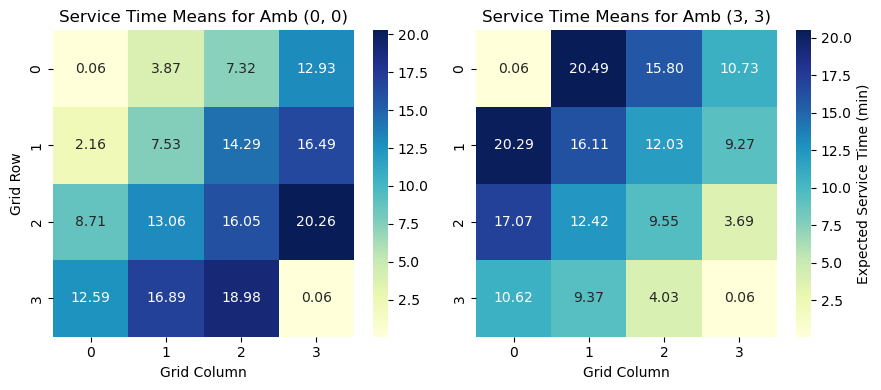

In [8]:
# transform expected service time values into a 4x4 grid for visualization
expected_service_time_grid = np.zeros((n, n, 2))
for i in range(n**2):
    x, y = grid_helper.index_to_coord(i)
    expected_service_time_grid[x, y, 0] = expected_service_time[i, 0]*60
    expected_service_time_grid[x, y, 1] = expected_service_time[i, 1]*60

# visualize the expected service time for each ambulance location side by side
plt.figure(figsize=(9, 4))
sns.heatmap(expected_service_time_grid[:, :, 0], annot=True, fmt=".2f", cmap="YlGnBu", ax=plt.subplot(1, 2, 1))
plt.title('Service Time Means for Amb (0, 0)')
plt.xlabel('Grid Column')
plt.ylabel('Grid Row') 
plt.subplot(1, 2, 2)
sns.heatmap(expected_service_time_grid[:, :, 1], annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Expected Service Time (min)'})
plt.title('Service Time Means for Amb (3, 3)')
plt.xlabel('Grid Column')
plt.tight_layout()
plt.show()


In [9]:
# probability of the service less than 10 minutes
coverage_reward_prob_high = np.vectorize(lambda x: 1 - math.exp(-(1/x) * 1/6))(expected_service_time) 
coverage_reward_prob_high

array([[1.        , 1.        ],
       [0.92433217, 0.38612315],
       [0.74512459, 0.46893545],
       [0.53859177, 0.60639189],
       [0.99033343, 0.38906748],
       [0.73485881, 0.46247119],
       [0.50324987, 0.56444574],
       [0.45472875, 0.65987482],
       [0.68275167, 0.44332483],
       [0.53511196, 0.55310168],
       [0.4636106 , 0.64902699],
       [0.38959541, 0.93353237],
       [0.54814303, 0.60997803],
       [0.44690918, 0.65598686],
       [0.40950099, 0.91649088],
       [1.        , 1.        ]])

In [11]:
coverage_reward_prob_high[0,0] = 0
coverage_reward_prob_high[0,1] = 0
coverage_reward_prob_high[n**2-1,0] = 0
coverage_reward_prob_high[n**2-1,1] = 0

In [10]:
coverage_reward_prob_low = coverage_reward_prob_high/500 #highly low reward for low priority patients
coverage_reward_prob_low

array([[0.002     , 0.002     ],
       [0.00184866, 0.00077225],
       [0.00149025, 0.00093787],
       [0.00107718, 0.00121278],
       [0.00198067, 0.00077813],
       [0.00146972, 0.00092494],
       [0.0010065 , 0.00112889],
       [0.00090946, 0.00131975],
       [0.0013655 , 0.00088665],
       [0.00107022, 0.0011062 ],
       [0.00092722, 0.00129805],
       [0.00077919, 0.00186706],
       [0.00109629, 0.00121996],
       [0.00089382, 0.00131197],
       [0.000819  , 0.00183298],
       [0.002     , 0.002     ]])

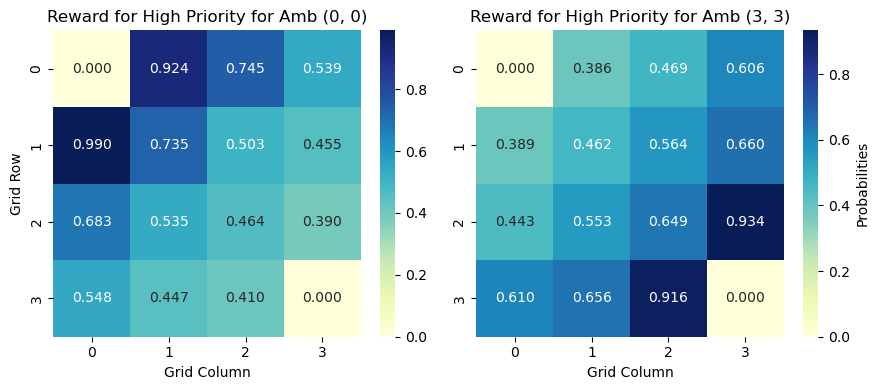

In [12]:
# transform reward values into a 4x4 grid for visualization
coverage_reward_high_grid = np.zeros((n, n, 2))
for i in range(n**2):
    x, y = grid_helper.index_to_coord(i)
    coverage_reward_high_grid[x, y, 0] = coverage_reward_prob_high[i, 0]
    coverage_reward_high_grid[x, y, 1] = coverage_reward_prob_high[i, 1]

# visualize the expected service time for each ambulance location side by side
plt.figure(figsize=(9, 4))
sns.heatmap(coverage_reward_high_grid[:, :, 0], annot=True, fmt=".3f", cmap="YlGnBu", ax=plt.subplot(1, 2, 1))
plt.title('Reward for High Priority for Amb (0, 0)')
plt.xlabel('Grid Column')
plt.ylabel('Grid Row') 
plt.subplot(1, 2, 2)
sns.heatmap(coverage_reward_high_grid[:, :, 1], annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Probabilities'})
plt.title('Reward for High Priority for Amb (3, 3)')
plt.xlabel('Grid Column')
plt.tight_layout()
plt.show()

In [13]:
# define an array with size 3 to keep the rewards for each ambulance, cell, and priority level
# coverage_reward[patient_index, ambulance_index, priority_level]
coverage_reward = np.zeros((n**2, 2, 2)) 

coverage_reward[:, 0, 0] = coverage_reward_prob_low[:, 0]  # all patients, first ambulance, low priority
coverage_reward[:, 0, 1] = coverage_reward_prob_high[:, 0] # all patients, first ambulance, high priority

coverage_reward[:, 1, 0] = coverage_reward_prob_low[:, 1] # all patients, second ambulance, low priority
coverage_reward[:, 1, 1] = coverage_reward_prob_high[:, 1] # all patients, second ambulance, high priority

In [14]:
arr_rate = 0.5          # arrivals per hour

#### Probability of a Request from the Cells

In [15]:
P = np.zeros(n**2) # arrival-location pmf
for i in range(n**2):
    # The first and last indices are the hospitals, so we set their probabilities to 0.
    # This means that the ambulance will never be dispatched to these locations.
    if i == 0 or i == n**2 - 1:
        P[i] = 0.0
    else:
        P[i] = np.random.uniform(0, 1)
P /= np.sum(P)
# round to 2 decimal points
P = np.round(P, 4)

In [16]:
P

array([0.    , 0.057 , 0.026 , 0.0983, 0.0336, 0.0715, 0.043 , 0.0066,
       0.1018, 0.1653, 0.0321, 0.1259, 0.129 , 0.0056, 0.1044, 0.    ])

In [17]:
print(np.sum(P))  # should be 1.0

1.0001


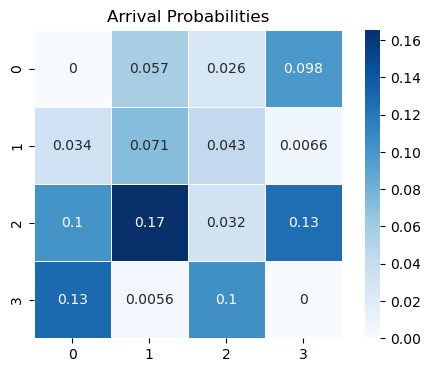

In [18]:
# heatmap representation of the arrival probabilities
plt.figure(figsize=(6, 4))
sns.heatmap(P.reshape(n, n), annot=True, cmap='Blues', square=True, linewidths=0.5)  
plt.title('Arrival Probabilities')
plt.xticks(ticks=np.arange(n) + 0.5, labels=np.arange(n))
plt.yticks(ticks=np.arange(n) + 0.5, labels=np.arange(n))
plt.grid(False)
plt.show()

#### Conditional Probability Values for High and Low Priority Patients

In [19]:
def assign_probabilities(size: int, low_range=(0.40, 0.60),  high_range=(0.40, 0.60)):
    
    probs = np.zeros((size, size), dtype=float)
    max_idx = size - 1

    for r in range(size):
        for c in range(size):
            # Skip the two corner cells – they stay at 0.
            if (r == 0 and c == 0) or (r == max_idx and c == max_idx):
                continue
            
            d_ul = r + c                          # distance to (0, 0)
            d_lr = (max_idx - r) + (max_idx - c)  # distance to (max_idx, max_idx)

            if d_ul < d_lr:                       # closer to upper-left
                probs[r, c] = random.uniform(*high_range)
            else:                                 # closer to lower-right
                probs[r, c] = random.uniform(*low_range)

    return probs


In [20]:
P_low = assign_probabilities(n)  # deterministic run
P_high = np.zeros(n**2)
P_high = 1 - P_low
P_high[0, 0] = 0.0  # hospital at (0, 0) has no probability
P_high[-1, -1] = 0.0  # hospital at (n

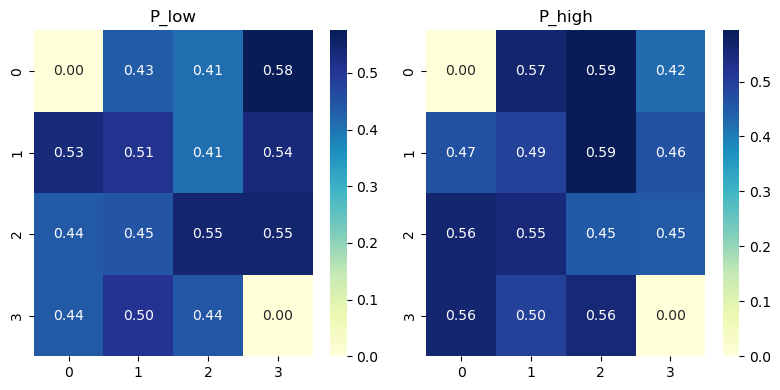

In [21]:
# show P_low and P_high heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(P_low.reshape(n, n),  annot=True, fmt=".2f", ax=axes[0], cmap="YlGnBu")
axes[0].set_title("P_low")  
sns.heatmap(P_high.reshape(n, n), annot=True, fmt=".2f", ax=axes[1], cmap="YlGnBu")
axes[1].set_title("P_high")
plt.tight_layout()
plt.show()

In [22]:
# combine P_low and P_high into two-dimensional array
P_pri_combined = np.zeros((2, n**2))
# assign P_low to first row and P_high to second row
P_pri_combined[0, :] = P_low.flatten()
P_pri_combined[1, :] = P_high.flatten()

### Actions

In [23]:
def actions(s):
    idle_providers = []
    if s[0] == 0:  idle_providers.append(0)   # provider at cell 0
    if s[1] == 0:  idle_providers.append(1)   # here 1 indicated the second ambulance which is at cell n**2 - 1
    return idle_providers if idle_providers else [None]   # None = null dispatch

### Event Rates

In [24]:
mu_max_0 = np.max(expected_service_time[:,0])
mu_max_1 = np.max(expected_service_time[:,1])

print("Maximum service time for ambulance 0:", mu_max_0)
print("Maximum service time for ambulance 1:", mu_max_1)

Maximum service time for ambulance 0: 0.3376325569390329
Maximum service time for ambulance 1: 0.3415573915738028


In [25]:
# this is needed for the normalization procedure. Here normalization is a process of transforming a continuous 
# Markov Decision Process (MDP) into a discrete one by scaling transition probabilities.
gamma = arr_rate + (1/(mu_max_0 + mu_max_1))
gamma

1.9723421661195293

## Transitions

In [26]:
def transitions(s, a):
    
    # input:  (state s, action a)
    # output: (next_state, prob, reward) !not one, all possible transitions starting from state s with an action a
    
    
    grid_size = n
    state_info = defaultdict(lambda: {"reward": 0.0, "prob": 0.0})

    # --- 1. Service completions ------------------------------------------
    for p_idx, provider_cell in enumerate((0, 1)): # to understand these, you need to remember the state representation which is a
        # tuple of two indices representing the ambulances' positions or 0 if the ambulance is idle. Also we have two ambulances which are
        # represented by indices 0 and 1.
        job = s[p_idx]
        if job != 0:
            rate   = expected_service_time[job, provider_cell]
            prob   = rate / gamma
            s_next = list(s)                # copy current state
            s_next[p_idx] = 0               # provider becomes idle
            state_info[tuple(s_next)]["reward"] += 0.0
            state_info[tuple(s_next)]["prob"]   += prob

    # --- 2. Customer arrival ---------------------------------------------
    prob_arr = arr_rate / gamma
    for i in range(grid_size**2):
        for j in range(2): # this is for two priorities (low(0) and high(1))
            if P[i] == 0:               # skip provider cells
                continue
            if a is None:               # both providers busy ⇒ null dispatch
                # here, you may want to count total number of request that are not served
                s_next = s             # state unchanged
                state_info[s_next]["reward"] += 0.0
                state_info[s_next]["prob"]   += prob_arr * P[i] * P_pri_combined[j, i]
            else:         # dispatch chosen idle provider
                p_idx = 0 if a == 0 else 1 # you can also use 'a' directly as an index since it is either 0 or 1
                s_next = list(s)
                s_next[p_idx] = i
                if s_next[0] == s_next[1]:  # the states where both ambulances are at the same location are not allowed such as (1,1) or (5,5).(0,0) is allowed tho.
                    s_next_no = s
                    state_info[s_next_no]["reward"] += 0.0
                    state_info[s_next_no]["prob"]   += prob_arr * P[i] * P_pri_combined[j, i]
                else:
                    state_info[tuple(s_next)]["reward"] += coverage_reward[i, a, j]
                    state_info[tuple(s_next)]["prob"]   += prob_arr * P[i] * P_pri_combined[j, i]
                             
    # --- 3. Dummy self-loop ----------------------------------------------
    total_prob = sum(s["prob"] for s in state_info.values())
 
    residual_prob = 1.0 - total_prob
    
    state_info[s]["reward"] += 0.0
    state_info[s]["prob"] += residual_prob

    # convert to list of tuples
    return [(ns, info["prob"], info["reward"]) for ns, info in state_info.items()]

In [27]:
gh = transitions((0, 0), 1)  # test transitions function with state (0, 0) and action 0
gh

[((0, 1), 0.014449825435751913, 0.38689539715384774),
 ((0, 2), 0.006591148444378065, 0.4698733211613921),
 ((0, 3), 0.024919611233937072, 0.6076046729631694),
 ((0, 4), 0.008517791835811655, 0.3898456116718354),
 ((0, 5), 0.01812565822203968, 0.46339612803608504),
 ((0, 6), 0.010900745504163725, 0.5655746297754174),
 ((0, 7), 0.0016731376820344323, 0.6611945648194371),
 ((0, 8), 0.025806881216834117, 0.44421148438247393),
 ((0, 9), 0.04190449376368055, 0.5542078808432699),
 ((0, 10), 0.00813753327171292, 0.6503250425739698),
 ((0, 11), 0.031916368813353795, 0.9353994329197284),
 ((0, 12), 0.03270223651249118, 0.6111979817529221),
 ((0, 13), 0.001419631972635276, 0.6572988333249129),
 ((0, 14), 0.02646599606127193, 0.9183238575912769),
 ((0, 0), 0.7464689400299036, 0.0)]

In [28]:
gh = transitions((0, 7), 0)  # test transitions function with state (0, 0) and action 0
gh

[((0, 0), 0.0783555715493393, 0.0),
 ((1, 7), 0.014449825435751913, 0.9261808365274937),
 ((2, 7), 0.006591148444378065, 0.7466148381602385),
 ((3, 7), 0.024919611233937072, 0.5396689499588992),
 ((4, 7), 0.008517791835811655, 0.9923140977731784),
 ((5, 7), 0.01812565822203968, 0.7363285254074956),
 ((6, 7), 0.010900745504163725, 0.5042563671268531),
 ((0, 7), 0.6697865061625989, 0.0),
 ((8, 7), 0.025806881216834117, 0.6841171724264707),
 ((9, 7), 0.04190449376368055, 0.5361821880529718),
 ((10, 7), 0.00813753327171292, 0.46453781838390473),
 ((11, 7), 0.031916368813353795, 0.3903746014704883),
 ((12, 7), 0.03270223651249118, 0.5492393209416632),
 ((13, 7), 0.001419631972635276, 0.4478030031029048),
 ((14, 7), 0.02646599606127193, 0.4103199921908325)]

## Relative Value Iteration

In [25]:
def rvi(eps=1e-8, max_iter=10000):
    V = np.zeros(len(states))
    # best action value for each state
    
    g = 0.0                             # bias estimate
    ref = 0                             # choose arbitrary reference state
 
    for it in range(max_iter):
        V_new = np.empty_like(V) # this will create a new array with the same shape and dtype as V but its contents are uninitialized
        g_num = 0.0

        for k, s in enumerate(states):
            best = -np.inf
            for a in actions(s):
                q = 0.0
                for ns, p, r in transitions(s, a): # this was already defined above. It's quite critical to understand how the transitions work
                    q += p * (r + V[state2idx[ns]])
                best = max(best, q)
            V_new[k] = best
            g_num  += best

        g_new = g_num / len(states)     # average over states
        V_new -= V_new[ref]             # anchor
        
        if it % 100 == 0:
            print(f"Iteration {it}, g = {g:.4f}, max |V_new - V| = {np.max(np.abs(V_new - V)):.10f}")
            
        if np.max(np.abs(V_new - V)) < eps:
            return g_new, V_new

        V, g = V_new, g_new

    raise RuntimeError("RVI failed to converge")

In [26]:
final_average_reward, V = rvi()

Iteration 0, g = 0.0000, max |V_new - V| = 0.0623881619
Iteration 100, g = -0.2961, max |V_new - V| = 0.0021158288
Iteration 200, g = -0.3011, max |V_new - V| = 0.0001924341
Iteration 300, g = -0.3015, max |V_new - V| = 0.0000192068
Iteration 400, g = -0.3015, max |V_new - V| = 0.0000019398
Iteration 500, g = -0.3015, max |V_new - V| = 0.0000001963
Iteration 600, g = -0.3015, max |V_new - V| = 0.0000000199


In [ ]:
#V

## Policy Generation

In a scenario with only two ambulances, the state (0,0) is of particular interest, as it represents the case where both ambulances are idle. If only one ambulance is available when a patient request arrives, that ambulance must be dispatched immediately—regardless of the request's priority level—since no other resources are free to respond.

In [27]:
# I need to find the best actions for the state (0, 0) which is the initial state where both ambulances are idle
# this is needed for each patient location and priority level

def best_actions():
    s = (0,0)
    best_actions = {}
    for i in range(n**2):
        if P[i] == 0:
            continue
        else:
            for pri in range(2):
                best_action = None
                best_value = -np.inf
                for a in actions(s):
                    s_next = s
                    s_next = list(s_next)
                    s_next[a] = i 
                    state_value = V[state2idx[tuple(s_next)]] # state value of the next state
                    immediate_reward = coverage_reward[i, a, pri] # immediate reward
                    value = state_value + immediate_reward
                    #print(f"State: {s}, Action: {a}, Next State: {s_next}, Priority: {pri}, Immediate: {immediate_reward}, StateValue: {state_value}, Total Value: {value}")
                    if value > best_value:
                        best_value = value
                        best_action = a
                best_actions[(i, pri)] = best_action
    return best_actions

In [28]:
all_best_actions = best_actions()

In [29]:
# for priority level 0 patients, show the best actions for each patient location on the grid 
best_action_grid_pri_0 = np.full((n, n), -1)
for i in range(n**2):
    if P[i] == 0:
        continue
    else:
        action = all_best_actions[(i, 0)]
        best_action_grid_pri_0[grid_helper.index_to_coord(i)] = action

# for priority level 1 patients, show the best actions for each patient location on the grid 
best_action_grid_pri_1 = np.full((n, n), -1)
for i in range(n**2):
    if P[i] == 0:
        continue
    else:
        action = all_best_actions[(i, 1)]
        best_action_grid_pri_1[grid_helper.index_to_coord(i)] = action

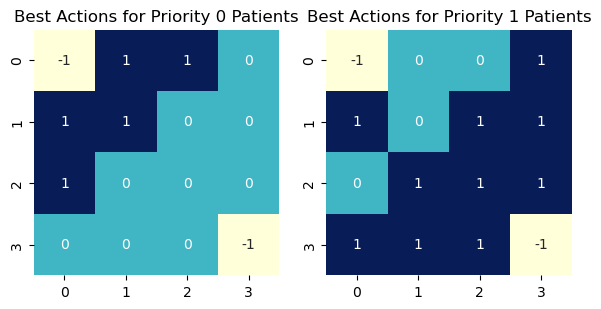

In [30]:
# visualize best_action_grid_pri_0 and best_action_grid_pri_1 on a heatmap and plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.heatmap(best_action_grid_pri_0, annot=True, fmt=".0f", ax=axes[0], cmap="YlGnBu", cbar=False, square=True)
axes[0].set_title("Best Actions for Priority 0 Patients")  
sns.heatmap(best_action_grid_pri_1, annot=True, fmt=".0f", ax=axes[1], cmap="YlGnBu", cbar=False, square=True)
axes[1].set_title("Best Actions for Priority 1 Patients")
plt.tight_layout()
plt.show()  